Neural Networks
=========================

## Handwritten digit classification using a Neural Network

*This example uses a single layer Neural Network to classify handwritten digits from a subset of the MNIST dataset*

### Import libraries 
We will mostly be using numpy for mathematical operations and matplotlib to produce plots 

In [33]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio            # for loading MAT files
import scipy.optimize as opt

### Load Data

In [34]:
# Load MAT file
mat = sio.loadmat("../data/digit_data")
'''	
    5000 Trainning examples
    20x20 pixels in each (400)
    Headers: 'X'(5000,400), 'y'(5000)
'''
X = mat['X']
y = mat['y'].flatten()

# Size of dataset
m = np.shape(X)[0] # samples
n = np.shape(X)[1] # features 

### Display Example of Digits

In [45]:
def displayData(X):

    # Create a greyscale image of the digits (m^(1/2))x(m^(1/2))
    example_width = int(round(np.sqrt(np.size(X, 1))))

    # samples, features
    [m,n] = np.shape(X)

    example_height = (n/example_width)

    # display grid dim
    disp_rows = np.floor(np.sqrt(m))
    disp_cols = np.ceil(m / disp_rows)

    # padding between images
    pad = 1

    # Array to display
    display_area = np.array(np.ones((int(pad + disp_rows * (example_height + pad)),
                                    int(pad + disp_cols * (example_width + pad)	 ))) )



    # wrap each example into a patch
    cur_ex = 0 
    for j in xrange(int(disp_rows)):
        for i in xrange(int(disp_cols)):

            # patch data
            patch = np.reshape(X[cur_ex,:],(example_height,example_width),order="F")

            # load into array
            yidx = ((j+1)*pad) + (example_height*j) 
            xidx = ((i+1)*pad) + (example_width*i)
            display_area[yidx:yidx+example_height,xidx:xidx+example_width] = patch

            cur_ex+=1
            if cur_ex > m:
                break

    # Display as a Matplotlib image
    plt.imshow(display_area,cmap='gray')
    plt.show()

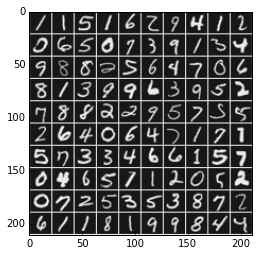

In [47]:
# Randomly select 100 data points to display
rand_indices = np.random.permutation(m);
sel = X[rand_indices[0:100], :]

# Display the randomly selected digits
displayData(sel)

### Single Layer Neural Net architecture

<img src="graphics/NN_single.png" width="450">

### Neural Network Parameters

In [35]:
### --------------------------- Neural Network --------------------------- ###
#% Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels 		  = 10   # 10 labels, from 1 to 10   
                         # (note that "0" is mapped to label 10 -> use 10%)
Lambda 			  = 0.1  # Regularisation parameter

### Initialise $\theta$ weights

In [36]:
def initweights(in_dim,out_dim,epsilon_init=0.12):
    #randomly initialise weights
    return np.random.rand(out_dim, 1 + in_dim)*(2*epsilon_init) - epsilon_init

In [37]:
# Initialise Weights
initial_Theta1 = initweights(input_layer_size, hidden_layer_size)
initial_Theta2 = initweights(hidden_layer_size, num_labels)
initial_nn_params = np.r_[initial_Theta1.ravel(), initial_Theta2.ravel()]

### Sigmoid Activation Function

$g(z) = \frac{1}{1+e^{-z}}$

In [38]:
def sigmoid(z):
    return np.divide(1.0, (np.add(1.0,np.exp(-z)) ) )

### Sigmoid Gradient

$g'(z) = \frac{d}{dz} g(z) = g(z)(1-g(z))$

In [39]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z),( (1 - sigmoid(z)) ) )

### Cost Function and Gradient with Regularisation

$J(\theta) = \frac{1}{m} \sum^m_{i=1} \sum^K_{k=1} [ -y_k^{(i)} log((h_\theta(x^{(i)})_k) - (1-y^{(i)}_k ) log(1 - (h_\theta (x^{(i)}))_k) ] + \frac{\lambda}{2m} [ \sum_{j=1}^{H_1} \sum_{k=1}^{n} (\Theta^{(1)}_{j,k})^2 + \sum_{j=1}^{K} \sum_{k=1}^{H_1} (\Theta^{(2)}_{j,k})^2  ]  $

where $H_1$ is the number of nodes in the $1^{st}$ Hidden Layer,

$m$ is the number of input samples,

$n$ is the number of features,

$K$ is the number of output classes

$j$ is the node in layer $l$

#### Backpropagation

<img src="graphics/NN_single_backprop.png" width="450">

for each output $k$

$ \delta_k^{(3)} = a_k^{(3)} - y_k$

where $y_k$ $\in$ {0,1}.

For $l=2$

$ \delta^{(2)} = (\Theta^{(2)})^{T} \delta^{(3)} .* g'(z^{(2)})  $

Accumulate the gradient

$\Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T$

NN Gradient (Regularised)

$\frac{d}{d\Theta^{(l)}_{ij}}J(\Theta) = \frac{1}{m}\Delta^{(l)}_{ij} $ for $j=0$

$\frac{d}{d\Theta^{(l)}_{ij}}J(\Theta) = \frac{1}{m}\Delta^{(l)}_{ij} + \frac{\lambda}{m}\Theta^{(l)}_{ij}$ for $j\geq 1$

In [40]:
def nnCost(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda,m):

    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels,(hidden_layer_size+1))

    # -- Feedforward -- #
    a1 = np.column_stack((np.ones(m),X))
    z2 = a1.dot(theta1.T) # 25x401 * 401x5000 = 25x5000 
    a2 = np.column_stack((np.ones(m),sigmoid( z2 )))
    a3 = sigmoid(a2.dot(theta2.T))

    # for every sample set the relevant idx (0-9) to 1 according to the labels
    yVec = np.zeros((int(m),num_labels))
    for i in xrange(int(m)):
        yVec[i,y[i]-1] = 1

    # Cost
    J = -(1.0/m) * np.sum( yVec * np.log( a3 ) + (1 - yVec) * np.log( 1 - a3 ) )  + \
        (Lambda/(2.0*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))

    # Calculate Gradients - Back Propagation 
    d3 = a3 - yVec 

    d2 = (theta2[:,1:].T.dot(d3.T))*sigmoid_gradient(z2).T 
    delta1 = d2.dot(a1) 
    delta2 = d3.T.dot(a2)

    theta1_ = np.c_[np.ones((theta1.shape[0],1)),theta1[:,1:]]
    theta2_ = np.c_[np.ones((theta2.shape[0],1)),theta2[:,1:]]

    theta1_grad = delta1/m + (theta1_*Lambda)/m
    theta2_grad = delta2/m + (theta2_*Lambda)/m

    grad = np.concatenate((theta1_grad.reshape(theta1_grad.size), theta2_grad.reshape(theta2_grad.size)))

    return J, grad

### Training

In [41]:
# Train 
maxiter = 40
myargs = (input_layer_size, hidden_layer_size, num_labels, X, y, Lambda,float(m))
results = opt.minimize(nnCost, x0=initial_nn_params, args=myargs, options={'disp': True, 'maxiter':maxiter}, 
                       method="L-BFGS-B", jac=True)

nn_params = results["x"]

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                 (hidden_layer_size, input_layer_size + 1)) 

Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                 (num_labels, hidden_layer_size + 1) ) 

### Predict

In [42]:
def predict(Theta1,Theta2,X):
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    a1 = np.column_stack((np.ones(np.shape(X)[0]),X))
    a2 = np.column_stack((np.ones(np.shape(X)[0]),sigmoid(a1.dot(Theta1.T))))
    a3 = sigmoid(a2.dot(Theta2.T))
    return np.argmax(a3, axis=1) 

In [44]:
# Feedforward and Prediction
pred = predict(Theta1,Theta2,X)
print "Accuracy on Training set: ", np.mean(pred+1 == y)*100.0, "%" 

Accuracy on Training set:  96.94 %


### Display Hidden Layer

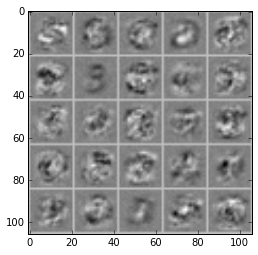

In [46]:
# Visualise Neural Network's Hidden Layer
displayData(Theta1[:,1:])

### Display and Predict

In [48]:
def displaydigit(idx,X):

    pixels = X[idx,:]
    digit = np.reshape(pixels, (20,20),order='F')
    plt.imshow(digit,cmap='gray')
    plt.show()

Neural Network Prediction: 7 (actual digit 7)


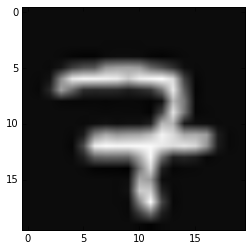

Neural Network Prediction: 9 (actual digit 9)


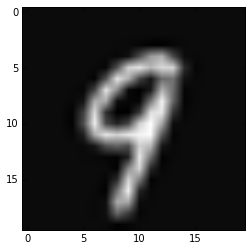

Neural Network Prediction: 0 (actual digit 0)


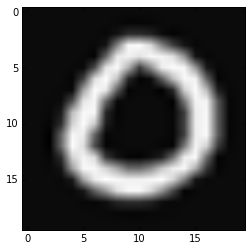

Neural Network Prediction: 4 (actual digit 4)


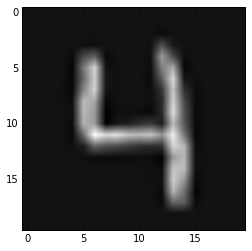

Neural Network Prediction: 0 (actual digit 0)


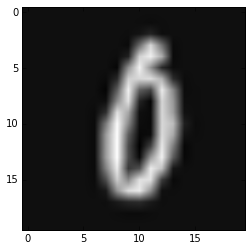

Neural Network Prediction: 8 (actual digit 8)


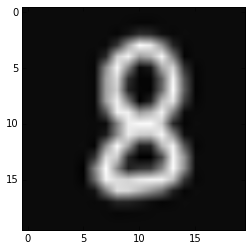

Neural Network Prediction: 2 (actual digit 2)


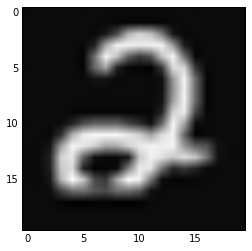

Neural Network Prediction: 3 (actual digit 3)


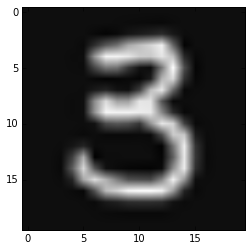

Neural Network Prediction: 6 (actual digit 6)


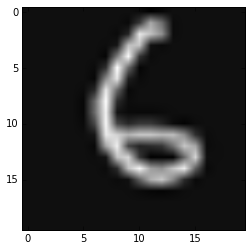

Neural Network Prediction: 0 (actual digit 0)


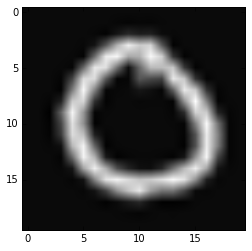

In [49]:
# Display samples and predict
rp = np.random.permutation(X.shape[0])
dispsamps = 10 # number of samples to display
for i in xrange(dispsamps):
    pred = predict(Theta1, Theta2, X[rp[i], :])
    print('Neural Network Prediction: {:d} (actual digit {:d})'.format((pred[0]+1)%10, y[rp[i]]%10)) 
    displaydigit(rp[i], X)